In [7]:
from pathlib import Path
path = Path('/home/ubuntu/code/looking-glass-')

## imports / setup

In [8]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [9]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import torch
import re

from torchvision import datasets
from torchvision import transforms

import utils
from transformer_net import TransformerNet
from vgg import Vgg16

from PIL import Image

import imageio

import torch.nn.functional as F

In [10]:
from functools import reduce

In [ ]:
import gc
# gc.collect()

In [12]:
device = torch.device(0) if torch.cuda.is_available() else torch.device('cpu')

In [17]:
def resize_img(img, size=256):
    MAXWIDTH = size
    h,w= img.size 
    ratio = MAXWIDTH/w
    return img.resize((int(h*ratio), int(w*ratio)), Image.ANTIALIAS)

def crop_img(img):
    h,w = img.size
    print(h,w, 255-h, 255-w)
    return img.crop((0, 30, w, h-30))
 
def scale_img(img, size=256):
    return img.resize((size, size), Image.ANTIALIAS)

def content_transform(img):
    np.array(x_img)
    
# content_transform = transforms.Compose([
#     transforms.ToTensor(), 
#     transforms.Lambda(lambda x: x.mul(255))
# ])



def content_transform(x):
    img = torch.from_numpy(np.array(x).transpose((2, 0, 1)))
    return img.float()

def convert_to_image(data):
    data = data.detach()
    img = data.clone()
    img = img.clamp(0, 255).numpy()
    img = img.transpose(1, 2, 0).astype("uint8")
    return Image.fromarray(img)

def pre_process_image(PIL_IMG, size=256):
    img = resize_img(PIL_IMG, size)
    img = scale_img(img, size)
    x = content_transform(img)
    x = x.unsqueeze(0).to(device)
    return x

In [22]:
x_img = Image.open(path/'photos/trump.jpeg')
y_img = Image.open(path/'photos/goldie.jpg') 

In [23]:
def get_data(yc_img, y_img, size=256):
    yc = pre_process_image(yc_img, size)
    y = pre_process_image(y_img, size)
    return yc, y

In [24]:
yc, y = get_data(x_img, y_img, 256)
yc.shape, y.shape

(torch.Size([1, 3, 256, 256]), torch.Size([1, 3, 256, 256]))

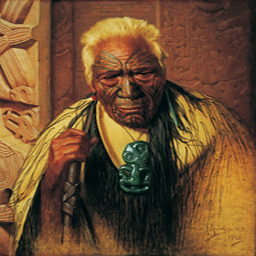

In [25]:
convert_to_image(y.cpu()[0])

In [28]:
vgg = Vgg16().to(device)
# style_model = TransformerNet().to(device)

In [29]:
yc_feats = vgg(yc)
y_hat_feats = vgg(yc)
y_feats = vgg(y)

In [30]:
yc_feats[0].shape

torch.Size([1, 64, 256, 256])


# feature loss function

$
\ell_{feat}^{\phi , j}(\hat{y}, y) = \frac{1}{C_{j}H_{j}W_{j} } \left\lVert \phi_{j}(\hat{y}) - \phi_{j}(y) \right\rVert
$

In [31]:
def layer_feat_loss(yj_hat, yj):
    normalise_by = 1 / yj_hat.numel()
    pairwise_dist = yj_hat - yj
    t_sum = torch.sum(pairwise_dist**2)
    t_sqrt = torch.sqrt(t_sum)
    return normalise_by * t_sqrt

In [32]:
layer_feat_loss(y_hat_feats[0], y_feats[0])

tensor(0.0432)

In [33]:
# check that the same tensor has 0 distance
fn = layer_feat_loss
assert(torch.eq(fn(y_feats[0], y_feats[0]),torch.tensor([0.])).item())

In [34]:
# def gram_matrix(x):
x = y_feats[1]

In [18]:
def gram_matrix(x):
    bs,c,h,w = x.shape
    
    # reshape features to C x H*W
    features = x.view(bs*c, h*w)
    
    # calculate gram matrix by mat mult
    gram = torch.matmul(features, features.t())
    # output is then shape C x C
    # gram.shape
    return gram.div(c*h*w)

In [19]:
gram_matrix(y_feats[1]).shape

torch.Size([128, 128])

# Style reconstruction loss



In [20]:
# per layer style reconstruction loss
def style_recon_loss(y_hat, y):
    gy_hat, gy = gram_matrix(y_hat), gram_matrix(y)
    dist = gy_hat - gy 
    dist_sq = dist**2
    t_sum = torch.sum(dist_sq)
    t_sqrt = torch.sqrt(t_sum)
    return t_sqrt * 1/gy_hat.numel()

In [21]:
style_recon_loss(y_hat_feats[1],y_feats[1])

tensor(0.3977, device='cuda:0')

In [22]:
# sum of style loss at each layer
def style_loss_layers(y_hat, y):
    l = y_hat.__len__()
    list_of_losses = torch.zeros(l).to(device)
    for i in range(0,l-1):
        list_of_losses[i] = style_recon_loss(y_hat[i], y[i])
    return torch.sum(list_of_losses)

In [23]:
style_loss_layers(y_hat_feats, y_feats)

tensor(1.3164, device='cuda:0')

# Optimization Method

In [24]:
from torch import nn

In [25]:
class Z_image(nn.Module):
    def __init__(self, size=256):
        super(Z_image, self).__init__()
        self.z = nn.Parameter(torch.rand([1,3,size,size]) ) 
    
    def forward(self): 
        return self.z

In [26]:
torch.rand([2])

tensor([0.2066, 0.2367])

# training



In [27]:
from torch.optim import Adam

In [28]:
model = Z_image(800).to(device)

In [29]:
y_feats = vgg(y)
yc_feats = vgg(yc)

In [30]:
def loss_fn(y_hat_feats):
    feat_loss = layer_feat_loss(y_hat_feats[3], yc_feats[3]) * 2
    style_loss = style_loss_layers(y_hat_feats, y_feats)
    total = torch.add(feat_loss, style_loss)
    return total, feat_loss, style_loss

In [31]:
def predict():
    pred = model().to(torch.device('cpu'))[0]
    return convert_to_image(pred)

In [32]:
opt = Adam(model.parameters(), 1e-1)

In [33]:
# save the picks from the whole training session
outputs = []

In [40]:
%%time
for e in range(0,9000):
    
    # paramter and loss fn
    y_hat = model()
    y_hat_feats = vgg(y_hat)
    loss, loss_feat, loss_style = loss_fn(y_hat_feats)
    
    if e % 100 == 0:
        print('loss total:, ', loss, 'style: ', loss_style, 'feat: ', loss_feat)
        print('epoch:, ', e)
        
    # our optimizer
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    if e % 100 == 0:
        outputs.append(predict())

loss total:,  tensor(2.0608, device='cuda:0', grad_fn=<AddBackward0>) style:  tensor(2.0449, device='cuda:0', grad_fn=<SumBackward0>) feat:  tensor(0.0159, device='cuda:0', grad_fn=<MulBackward0>)
epoch:,  0
loss total:,  tensor(1.9987, device='cuda:0', grad_fn=<AddBackward0>) style:  tensor(1.9829, device='cuda:0', grad_fn=<SumBackward0>) feat:  tensor(0.0158, device='cuda:0', grad_fn=<MulBackward0>)
epoch:,  100
loss total:,  tensor(1.9441, device='cuda:0', grad_fn=<AddBackward0>) style:  tensor(1.9283, device='cuda:0', grad_fn=<SumBackward0>) feat:  tensor(0.0158, device='cuda:0', grad_fn=<MulBackward0>)
epoch:,  200
loss total:,  tensor(1.8938, device='cuda:0', grad_fn=<AddBackward0>) style:  tensor(1.8780, device='cuda:0', grad_fn=<SumBackward0>) feat:  tensor(0.0158, device='cuda:0', grad_fn=<MulBackward0>)
epoch:,  300
loss total:,  tensor(1.8456, device='cuda:0', grad_fn=<AddBackward0>) style:  tensor(1.8297, device='cuda:0', grad_fn=<SumBackward0>) feat:  tensor(0.0159, device

In [41]:
l = int(outputs.__len__()/2)
step = 2
pics = [ outputs[i*step] for i in range(0,l, step)]
pics_l = len(pics)

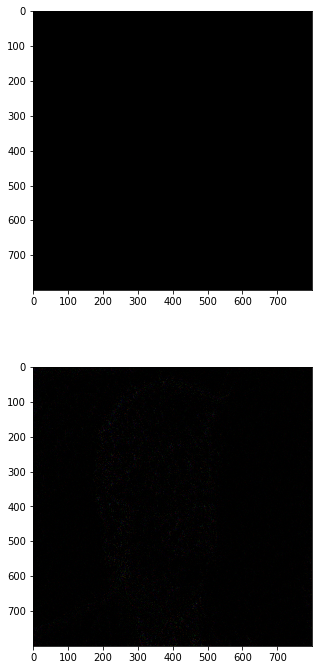

In [36]:
fig, axes = plt.subplots(pics_l, 1, figsize=(5, pics_l*6) )

for i,x in enumerate(pics):
    axes[i].imshow(x)

In [43]:
imageio.mimsave(path/'movie2.gif', pics)

In [ ]:
pred = model()

In [ ]:
pred